In [1]:
import pandas as pd

In [2]:
import sys
sys.path.append("../loaders/weather_station")

In [3]:
import weather_reports

In [4]:
source = pd.read_csv("../data/source.csv", parse_dates=True)
source[["start", "end"]] = source[["start", "end"]].astype("datetime64[ns]")
source.dtypes

Circuit                                 object
Weather Station                         object
Wind Sustained                         float64
Gust Sustained                         float64
Thresholds (Sustained/ Gust)            object
FPI Value                              float64
Reasons for De‐Energization             object
month                                   object
days                                    object
year                                     int64
Wind Threshold                         float64
Gust Threshold                         float64
Wind Trigger Percentage                float64
Gust Trigger Percentage                float64
Combined Trigger Percentage            float64
event start                              int64
event end                                int64
start                           datetime64[ns]
end                             datetime64[ns]
start day                                int64
end day                                  int64
dtype: object

In [5]:
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)
ws.dtypes

StationNbr          int64
Name               object
City               object
RegionalOffice     object
County             object
ConnectDate        object
DisconnectDate     object
IsActive             bool
IsEtoStation         bool
Elevation           int64
GroundCover        object
HmsLatitude        object
HmsLongitude       object
ZipCodes           object
SitingDesc        float64
dtype: object

In [6]:
sce_ws = source["Weather Station"].unique()
api_ws = ws.Name
matches = {}
for n in api_ws:
    for w in sce_ws:
        if n.lower() in w.lower() and n not in matches:
            matches[n]=w

In [7]:
ws_matches = ws[ws.Name.isin(matches.keys())]
ws_matches["Name"] = ws_matches.Name.apply(lambda s: matches[s])
source_ws = source.merge(ws_matches, left_on="Weather Station", right_on="Name")

<ipython-input-7-e1dcc0573538>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_matches["Name"] = ws_matches.Name.apply(lambda s: matches[s])


In [8]:
ws_query = source_ws[["StationNbr", "start", "end"]]
ws_query = ws_query[~ws_query.duplicated()]

In [9]:
# look at data the day before/after the event
oneday = pd.Timedelta(days=1)
ws_query.start = ws_query.start - oneday
ws_query.end = ws_query.end + oneday

In [10]:
query = ws_query.astype(str).values
query

array([['6', '2020-11-28', '2020-11-30'],
       ['6', '2020-12-15', '2020-12-25'],
       ['6', '2020-12-03', '2020-12-15'],
       ['6', '2021-01-11', '2021-01-22'],
       ['98', '2020-11-28', '2020-11-30'],
       ['238', '2020-11-28', '2020-11-30'],
       ['58', '2020-11-28', '2020-11-30'],
       ['198', '2020-11-28', '2020-11-30'],
       ['58', '2021-01-11', '2021-01-22'],
       ['198', '2021-01-11', '2021-01-22'],
       ['28', '2020-11-28', '2020-11-30'],
       ['217', '2020-11-28', '2020-11-30'],
       ['251', '2020-12-03', '2020-12-15'],
       ['250', '2020-12-03', '2020-12-15'],
       ['74', '2020-12-03', '2020-12-15'],
       ['74', '2021-01-11', '2021-01-22'],
       ['255', '2021-01-11', '2021-01-22']], dtype=object)

In [11]:
# go off and use ye old query module
wr = weather_reports.weather_station_query(query, save=True)
wr.head()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [41]:
wr = pd.read_csv("../data/weather/weather_report.csv")

In [42]:
wr.Station.value_counts()

6      744
251    264
250    264
198    264
255    240
217     24
Name: Station, dtype: int64

In [45]:
station = 198
wrs = wr[wr.Station == station]
wrs.Date

744     2020-11-29
745     2020-11-29
746     2020-11-29
747     2020-11-29
748     2020-11-29
           ...    
1003    2021-01-21
1004    2021-01-21
1005    2021-01-21
1006    2021-01-21
1007    2021-01-21
Name: Date, Length: 264, dtype: object

(<AxesSubplot:>, 204)

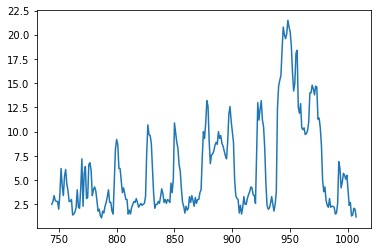

In [44]:
wrs["HlyWindSpd (MPH)"].plot(), wrs["HlyWindSpd (MPH)"].argmax()

<AxesSubplot:>

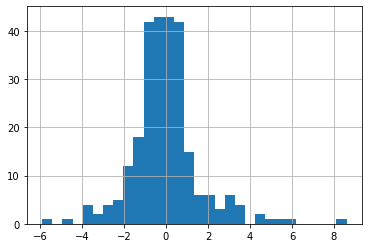

In [59]:
wrs["HlyWindSpd (MPH)"].diff().hist(bins=30)

(<AxesSubplot:>, 157)

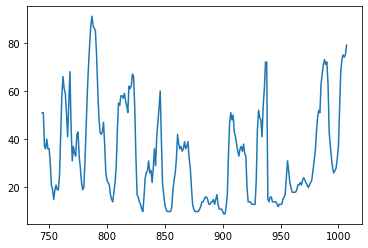

In [50]:
wrs["HlyRelHum (%)"].plot(), wrs["HlyRelHum (%)"].argmin()

<AxesSubplot:>

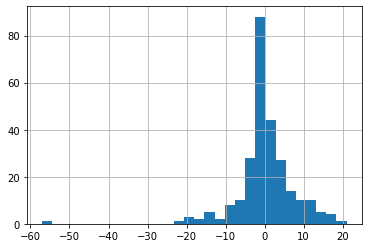

In [60]:
wrs["HlyRelHum (%)"].diff().hist(bins=30)